# Original dataset modeling

Student name: Sam Oliver <br>
Student pace: self-paced <br>
Scheduled project review: 10/18/2022 3:00 PM EST <br>
Instructor name: Abhineet Kulkarni

Preface for this notebook: If not already noted, please reference the README and preferably the STRIP.ipynb notebook (Google Colab notebook). There is information on this project, evaluation methods, notes on the datasets used, etc.

## Dataset description

This notebook will focus on modeling with the [original dataset used in this Kaggle competition](https://www.kaggle.com/competitions/mayo-clinic-strip-ai/data). This dataset contains 1,158 different files with a size of about 400 GB. Here is a more detailed description found of each file and data field: <br>
1. train - A folder containing images in the TIFF format to be used as training data.
2. test - A folder containing images to be used as test data. The actual test data comprises about 280 images.
3. train.csv Contains annotations for images in the train/ folder. 
* image_id - A unique identifier for this instance having the form {patient_id}_{image_num}. Corresponds to the image {image_id}.tif.
* center_id - Identifies the medical center where the slide was obtained.
* patient_id - Identifies the patient from whom the slide was obtained.
* image_num - Enumerates images of clots obtained from the same patient.
* label - The etiology of the clot, either CE or LAA. This field is the classification target.
4. test.csv - Annotations for images in the test/ folder. Has the same fields as train.csv excluding label.
5. other.csv - Annotations for images in the other/ folder. Has the same fields as train.csv. The center_id is unavailable for these images however.
* label - The etiology of the clot, either Unknown or Other.
* other_specified - The specific etiology, when known, in case the etiology is labeled as Other.
6. sample_submission.csv - A sample submission file in the correct format. 

## Evaluating modeling results

The evaluation algorithm is a weighted multi-class logarithmic loss that produces an effect of placing equal **importance on each category** for the final score.
The formula is as follows:

![eval](./images/eval_form.png)


Definitions of elements in the formula:
* M - number of classes
* N - number of images in the class set
* y_ij - equal to 1 if observation i belongs to class j and 0 otherwise
* p_ij - predicted probability that image i belongs to class j.
* w_i - the weight of each class. w1 = w2 = 0.5 because both classes are weighted equally.

This formula is essentially the same as the binary cross entropy log loss formula (at least for this binary classification problem). I used the binary cross entropy log loss formula to evaluate my models because it is intuitively built into the modeling applications I used. The formula is below:

![bin_x](./images/bin_x.png)

As can be seen, it is practically the same, and the two formulas reward and penalize predictions in the same way for binary classification problems.

The evaluation formula has the following effect:

![pen_reward](./images/competitionMetricExplanation.png)

As visualized here, very bad predictions are heavily penalized while good predictions are rewarded and the more confident good predictions are, the more reward there is.

## Import packages and data

In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import os
from os import listdir
from pathlib import Path

from skimage.io import imread
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import cv2
from numpy import asarray

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras import activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# from keras.utils.vis_utils import plot_model to display Neural Networks
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

from keras.models import load_model
import keras.applications

import datetime
from tqdm import tqdm

from tensorflow.random import set_seed
set_seed(13)

In [2]:
train_df = pd.read_csv(r'C:\Users\18016\Downloads\train\.csv')
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


Each patient has an id, each image has an id, the center id (0-11) is unique identifier for each center that contributed images to the registry. image_num references how many images are represented for the unique patient id. Label references whether the stroke occurred as cardioembolic or large artery atherosclerosis.

Append the paths for the images below.

In [3]:
train_path = r"C:\\Users\\18016\\Downloads\\train\\"
train_df["file_path"] = train_df["image_id"].apply(lambda x: train_path + x + ".tif")
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path
0,006388_0,11,006388,0,CE,C:\\Users\\18016\\Downloads\\train\\006388_0.tif
1,008e5c_0,11,008e5c,0,CE,C:\\Users\\18016\\Downloads\\train\\008e5c_0.tif
2,00c058_0,11,00c058,0,LAA,C:\\Users\\18016\\Downloads\\train\\00c058_0.tif
3,01adc5_0,11,01adc5,0,LAA,C:\\Users\\18016\\Downloads\\train\\01adc5_0.tif
4,026c97_0,4,026c97,0,CE,C:\\Users\\18016\\Downloads\\train\\026c97_0.tif


OpenSlide package will allow for opening and processing of the Whole Slide images (the .tif images represented by the paths in the train_df file_path column). 

Add openslide path for bin file. Need to add the dll directory file in so OpenSlide builds necessary references.

In [4]:
OPENSLIDE_PATH = r'C:\Users\18016\Desktop\openslide-win64-20220811\bin'

if hasattr(os, 'add_dll_directory'):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [5]:
from openslide import OpenSlide

## Preview some images

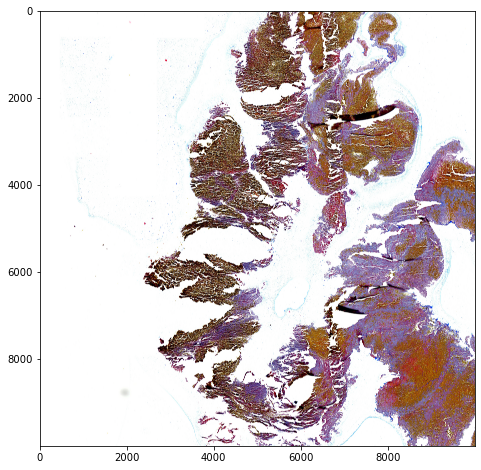

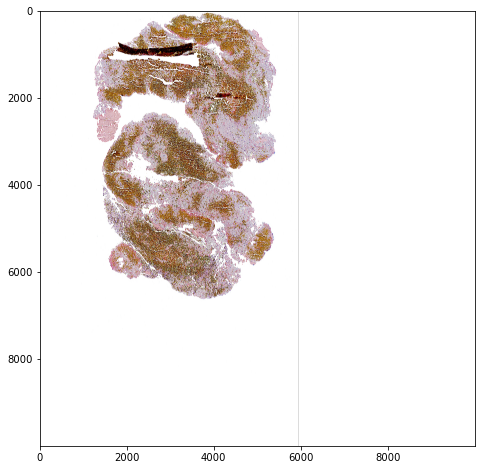

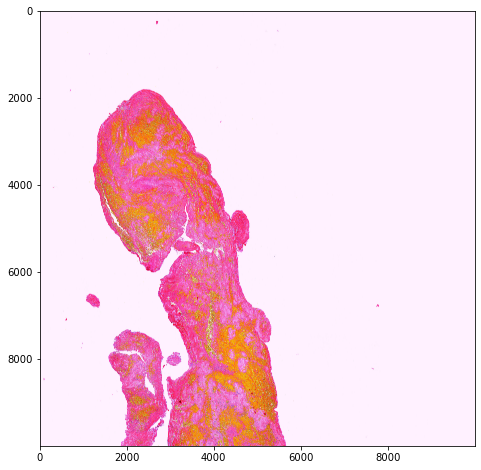

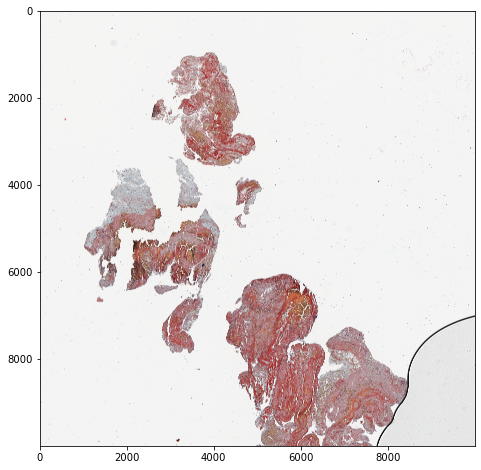

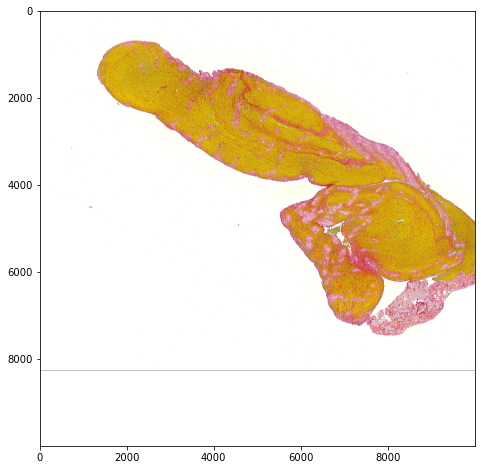

In [6]:
sample_train = train_df[:5]

for i in range(5):
    slide = OpenSlide(sample_train.loc[i, "file_path"])
    region = (0, 0)
    size = (10000, 10000)
    region = slide.read_region(region, 0, size)
    plt.figure(figsize=(8, 8))
    plt.imshow(region)
    plt.show()

I wonder if those dark black bands are any indication of a cardioembolic stroke? Also, what are these dark black bands?<br> The bottom right corner of the last image (LAA type) is interesting as well- does that indicate some issue with how the clot was scanned?<br> I'm interested in if the center in which the image was taken could be a significant attribute in modeling...

## Preview pixel intensity distribution of some images

Viewing a pixel intensity distribution of the images might help with identifying differences between the two categories.

First, I'm going to create a function that can read in images and allow them to be passed to another function to plot and display their pixel distributions.

In [7]:
# give the file path and read the image in as OpenSlide object (PIL type)
# input row number and df where the file path is located
# df should have row called "file_path" where the image path is located

def read_images(row, df):
    slide = OpenSlide(df.loc[row, "file_path"])
    region = (0, 0)
    size = (10000, 10000)
    region = slide.read_region(region, 0, size)
    region = asarray(region)     # convert to array
    region = np.divide(region, 255)      # normalize
    
    return region

Adapting this function from Morgan Jones' work on identifying patterns in COVID-19 chest x-rays. You can find his work [here](https://github.com/MoJoMoon/Identifying-COVID-19-with-Deep-Learning/blob/master/student.ipynb).

In [8]:
# Create a function that plots pixel intensities
def plotHistogram(row, df):
    """
    Plot histogram of RGB Pixel Intensities
    """
    # pass path to read_images to create PIL image
    a = read_images(row, df)
    print("The category for the following image is " + df.loc[row, "label"])
    
    # plot the image alongside the pixel distribution
    plt.figure(figsize=(8, 8))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    his = plt.subplot(1,2,2)
    his.set_ylabel('Count')
    his.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
    plt.show()

The category for this image is CE


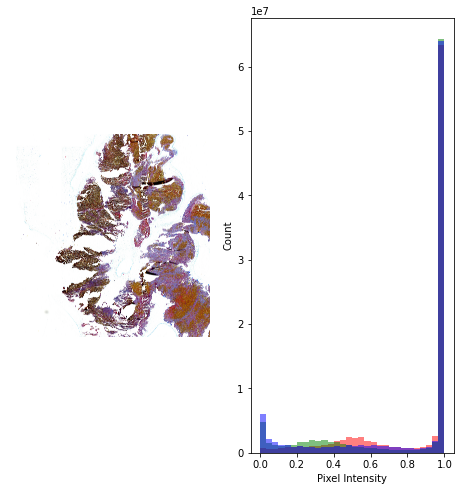

The category for this image is CE


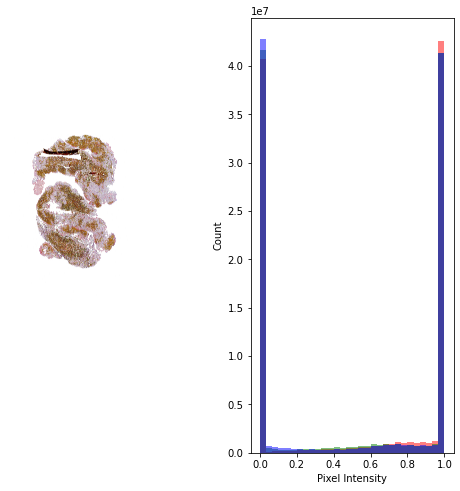

The category for this image is LAA


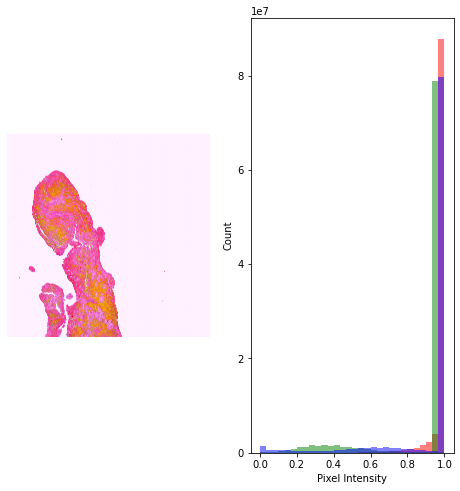

The category for this image is LAA


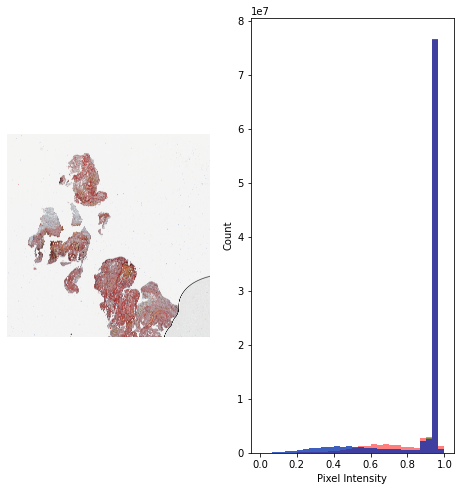

The category for this image is CE


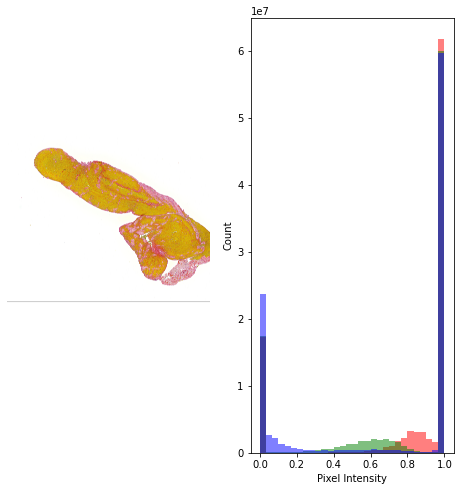

In [42]:
# Show image and histogram of pixel intensities
for i in range(5):
    plotHistogram(i, sample_train)

Both categories typically have very intense pixels in one or more categories, and it also seems normal for both categories to have many pixels that are of low intensity- which is due to the amount of whitespace present in these images.

## Clean the dataset

In the STRIP.ipynb notebook, it is noted that there are several images that are blurry and could corrupt future predictions. I will remove these images from this dataset.

In [9]:
# remove following ids from train_df:
# b894f4_0, 6baf51_0, 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0
train_df = train_df[(train_df.image_id != 'b894f4_0') & 
                     (train_df.image_id != '6baf51_0') & 
                     (train_df.image_id != '7b9aaa_0') &
                     (train_df.image_id != '5adc4c_0') & 
                     (train_df.image_id != 'bb06a5_0') & 
                     (train_df.image_id != 'e26a04_0')]

# also, reset the index of train_df
train_df = train_df.reset_index(drop=True)

# check changes
train_df

,image_id,center_id,patient_id,image_num,label,file_path
0,006388_0,11,006388,0,CE,C:\\Users\\18016\\Downloads\\train\\006388_0.tif
1,008e5c_0,11,008e5c,0,CE,C:\\Users\\18016\\Downloads\\train\\008e5c_0.tif
2,00c058_0,11,00c058,0,LAA,C:\\Users\\18016\\Downloads\\train\\00c058_0.tif
3,01adc5_0,11,01adc5,0,LAA,C:\\Users\\18016\\Downloads\\train\\01adc5_0.tif
4,026c97_0,4,026c97,0,CE,C:\\Users\\18016\\Downloads\\train\\026c97_0.tif
...,...,...,...,...,...,...
743,fe9645_0,3,fe9645,0,CE,C:\\Users\\18016\\Downloads\\train\\fe9645_0.tif
744,fe9bec_0,4,fe9bec,0,LAA,C:\\Users\\18016\\Downloads\\train\\fe9bec_0.tif
745,ff14e0_0,6,ff14e0,0,CE,C:\\Users\\18016\\Downloads\\train\\ff14e0_0.tif
746,ffec5c_0,7,ffec5c,0,LAA,C:\\Users\\18016\\Downloads\\train\\ffec5c_0.tif


Looks good. 748 items is the amount I should have.

## Image transformations

Preprocessing the images because they are very large. Resizing to 512x512 pixels to try to avoid running out of memory. <br> Also converting images to 3 channels and converting to image array to avoiding OOM. Opening the image with OpenSlide package, which specializes in opening digital pathology Whole Slide images and .tif images.

In [10]:
def preprocess(image_path):
    slide = OpenSlide(image_path)     # create OpenSlide image object
    region = (0, 0)     # start at bottom left corner
    size = (10000, 10000)     # size is square 10kx10k pixels starting from 0
    image = slide.read_region(region, 0, size)     # read image with params
    image = image.resize(size=(512,512)).convert('RGB')     # resizing to 512x512
    image_arr = np.array(image)    # convert image to array
    return image_arr

Reading in each image from the bottom left and going up and to the right by 10k pixels. This technique certainly isn't great for *every* image, but I think it's probably a decent strategy that still avoids OOM issues.

In [11]:
# apply function to images

# create copy of train_df to apply changes to
tdf = train_df.copy()
image_arrays = []

for i in tqdm(tdf['file_path']):
    img_a = preprocess(i)
    image_arrays.append(img_a)
    
tdf['img_arr'] = image_arrays

tdf.head()

100%|██████████| 748/748 [40:12<00:00,  3.22s/it]


,image_id,center_id,patient_id,image_num,label,file_path,img_arr
0,006388_0,11,006388,0,CE,C:\\Users\\18016\\Downloads\\train\\006388_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,008e5c_0,11,008e5c,0,CE,C:\\Users\\18016\\Downloads\\train\\008e5c_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,00c058_0,11,00c058,0,LAA,C:\\Users\\18016\\Downloads\\train\\00c058_0.tif,"[[[255, 241, 255], [255, 241, 255], [255, 241,..."
3,01adc5_0,11,01adc5,0,LAA,C:\\Users\\18016\\Downloads\\train\\01adc5_0.tif,"[[[246, 246, 244], [245, 246, 244], [246, 246,..."
4,026c97_0,4,026c97,0,CE,C:\\Users\\18016\\Downloads\\train\\026c97_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


Converted images to arrays. Easier on memory this way...

Use an ImageDataGenerator to normalize and permute the images.

In [12]:
# use a simple kind of ImageDataGenerator
permutes = ImageDataGenerator(
    rescale = 1. / 255,     # normalize the data - all data points btwn 0-1
    shear_range = 0.2,     # this distorts the image along an axis
    zoom_range = 0.1,     # range for random zoom
    horizontal_flip = True     # random horizontal flip
)

## Train-test split

Split data into train and test dataframes to use for modeling. Using standard split size of 80-20 train to test % composition.

In [13]:
# also make a target column because I will need int labels for modeling

# 0 - CE & 1 - LAA
tdf["target"] = tdf["label"].apply(lambda x : 0 if x=="CE" else 1)

In [14]:
df_tt = tdf.copy()
train, test = train_test_split(df_tt, test_size=0.2, random_state=42, 
                               shuffle=True)

train

,image_id,center_id,patient_id,image_num,label,file_path,img_arr,target
593,d2c18a_0,11,d2c18a,0,LAA,C:\\Users\\18016\\Downloads\\train\\d2c18a_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
131,2b7304_1,3,2b7304,1,LAA,C:\\Users\\18016\\Downloads\\train\\2b7304_1.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
44,0d4164_0,11,0d4164,0,CE,C:\\Users\\18016\\Downloads\\train\\0d4164_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
70,15de51_0,4,15de51,0,LAA,C:\\Users\\18016\\Downloads\\train\\15de51_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
670,e9c181_0,10,e9c181,0,CE,C:\\Users\\18016\\Downloads\\train\\e9c181_0.tif,"[[[255, 250, 255], [255, 250, 255], [255, 250,...",0
...,...,...,...,...,...,...,...,...
71,162cad_0,11,162cad,0,LAA,C:\\Users\\18016\\Downloads\\train\\162cad_0.tif,"[[[255, 241, 255], [255, 241, 255], [255, 241,...",1
106,23d2c1_1,7,23d2c1,1,CE,C:\\Users\\18016\\Downloads\\train\\23d2c1_1.tif,"[[[234, 216, 254], [234, 216, 254], [234, 216,...",0
270,56d177_2,7,56d177,2,CE,C:\\Users\\18016\\Downloads\\train\\56d177_2.tif,"[[[234, 216, 254], [234, 216, 254], [234, 216,...",0
435,91fee7_0,8,91fee7,0,CE,C:\\Users\\18016\\Downloads\\train\\91fee7_0.tif,"[[[255, 241, 255], [255, 241, 255], [255, 241,...",0


Ensure split worked...

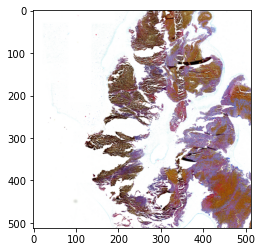

In [15]:
plt.imshow(train.img_arr[0])
plt.show()

## Preview pixel distribution of permuted images

I think it will be interesting to take a look at the pixel distribution of the altered images and see if there are patterns.

Sub sample the train dataset and reset the index so that the correct datatypes can be passed to the pixel histogram plotting function.

In [25]:
sub_train = train[:10].reset_index(drop=True)
sub_train

,image_id,center_id,patient_id,image_num,label,file_path,img_arr,target
0,d2c18a_0,11,d2c18a,0,LAA,C:\\Users\\18016\\Downloads\\train\\d2c18a_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
1,2b7304_1,3,2b7304,1,LAA,C:\\Users\\18016\\Downloads\\train\\2b7304_1.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
2,0d4164_0,11,0d4164,0,CE,C:\\Users\\18016\\Downloads\\train\\0d4164_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
3,15de51_0,4,15de51,0,LAA,C:\\Users\\18016\\Downloads\\train\\15de51_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
4,e9c181_0,10,e9c181,0,CE,C:\\Users\\18016\\Downloads\\train\\e9c181_0.tif,"[[[255, 250, 255], [255, 250, 255], [255, 250,...",0
5,45c6ce_0,11,45c6ce,0,CE,C:\\Users\\18016\\Downloads\\train\\45c6ce_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
6,719165_0,11,719165,0,CE,C:\\Users\\18016\\Downloads\\train\\719165_0.tif,"[[[234, 216, 254], [234, 216, 254], [234, 216,...",0
7,d923a7_0,11,d923a7,0,CE,C:\\Users\\18016\\Downloads\\train\\d923a7_0.tif,"[[[255, 241, 255], [255, 241, 255], [255, 241,...",0
8,2c64b2_0,11,2c64b2,0,LAA,C:\\Users\\18016\\Downloads\\train\\2c64b2_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
9,a45bac_0,11,a45bac,0,CE,C:\\Users\\18016\\Downloads\\train\\a45bac_0.tif,"[[[243, 243, 244], [243, 244, 244], [244, 244,...",0


The category for the following image is LAA


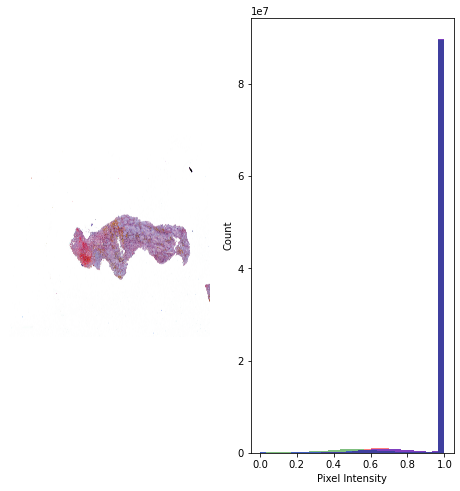

The category for the following image is LAA


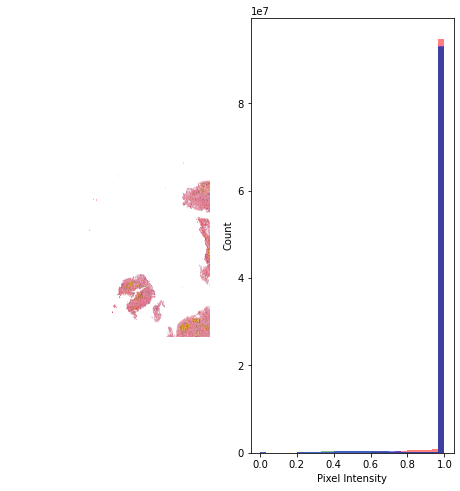

The category for the following image is CE


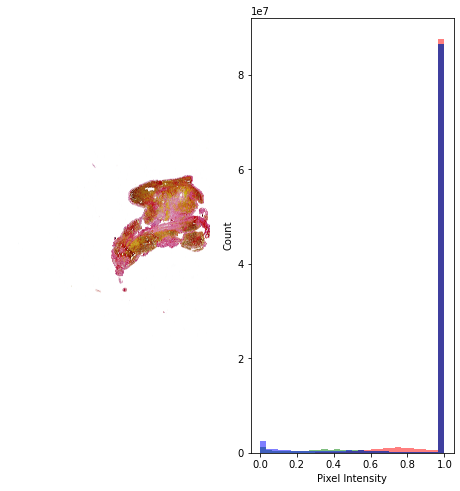

The category for the following image is LAA


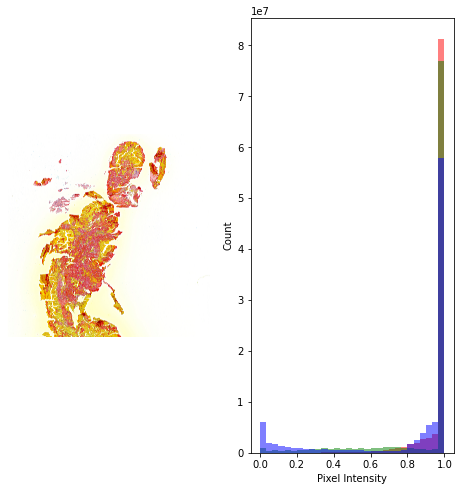

The category for the following image is CE


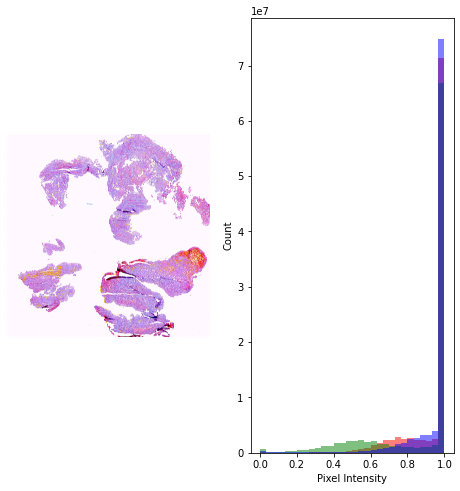

The category for the following image is CE


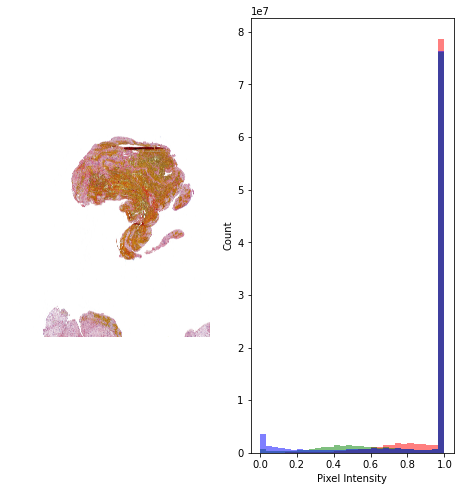

The category for the following image is CE


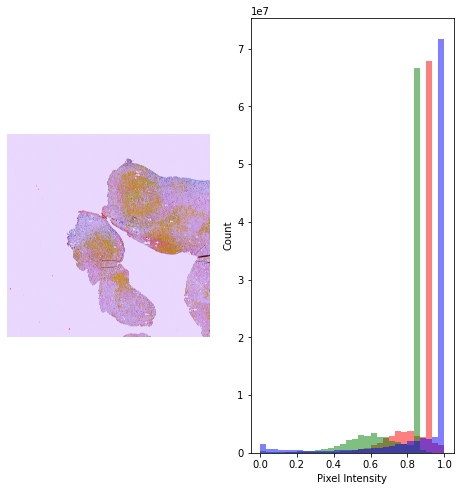

The category for the following image is CE


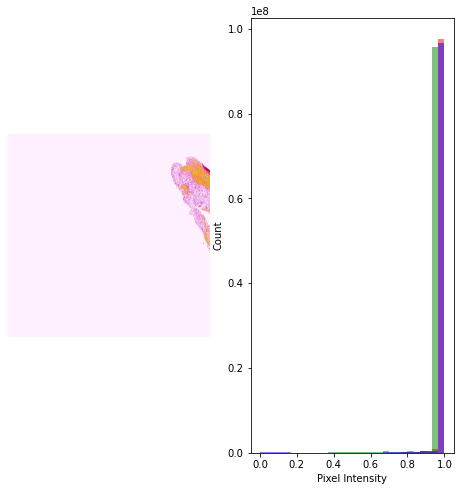

The category for the following image is LAA


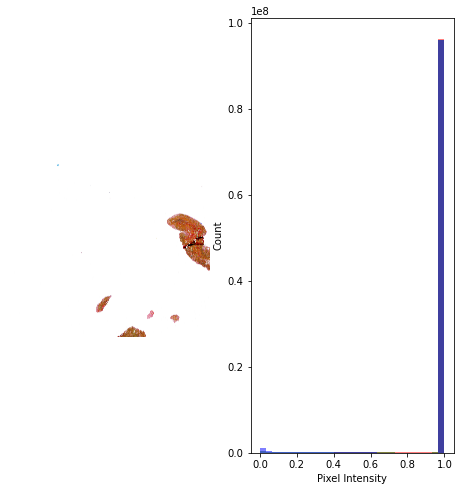

The category for the following image is CE


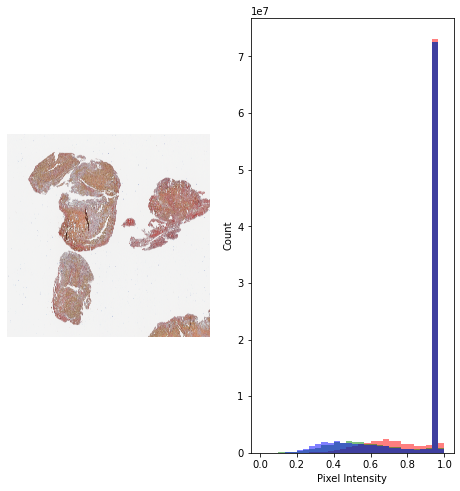

In [27]:
# Show image and histogram of pixel intensities
for i in range(10):
    plotHistogram(i, sub_train)

# Modeling

## Helper function for evaluation

Print out loss, RMSE, MAE, plots for these metrics, confusion matrix, and classification report. 

In [28]:
def evaluate_model(history, model, test):
  # print loss and accuracy of the model on the test set
    test_loss, test_rmse, test_mae = history.model.evaluate(
      x=np.array(test['img_arr'].to_list()), 
      y=test['target']
    )
    print(f'Test Loss: {test_loss}')
    print(f'Test RMSE: {test_rmse}')
    print(f'Test MAE: {test_mae}')

    # create plots for accuracy and loss
    fig, ax = plt.subplots(1, 2, figsize = (12,8))
    ax[0].plot(history.history['rmse'])
    ax[0].plot(history.history['val_rmse'])
    ax[0].set_title('Model RMSE')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('RMSE')
    ax[0].legend(['Train', 'Test'], loc='upper left')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

    # plot confusion matrix - create predictions for the model
    y_hat_tmp = history.model.predict(
        x=np.array(test['img_arr'].to_list())
    )

    # classify y_hat as either 0 or 1 based on if val is < or >= to 0.5
    thresh = 0.5
    y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values
    y_t = test.target.astype(int)
    cm_vals = confusion_matrix(y_t, y_hat)     # get confusion matrix values

    # plot confusion matrix values
    sns.heatmap(
      cm_vals, 
      annot=True, 
      cmap='Blues', 
      fmt='0.5g'
    )
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Baseline Model Confusion Matrix')
    plt.show()

    # display classification report
    print(classification_report(y_t, y_hat))

## Baseline model

Going to create simple CNN architecture for the first model.

### Define Callbacks

In [29]:
# Going to use EarlyStopping Callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Instantiate ModelCheckpoint Callback
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', 
                     save_best_only=True)

### Create and fit the model

Build out simple model.

In [30]:
model = models.Sequential()
input_shape = (512, 512, 3)

model.add(Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same',
                 activation = 'relu', input_shape = input_shape))
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'same',
                 activation = 'relu'))
model.add(Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same',
                 activation = 'relu'))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(1))

model.compile(
    loss = 'binary_crossentropy',    
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse"), 'mae'],
    optimizer = tf.keras.optimizers.Adam(1e-3)
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [40]:
# visualize the model architecture
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
history = model.fit(
    x=np.array(train['img_arr'].to_list()),
    y=train['target'],
    batch_size=16,
    epochs=50,
    callbacks=[es, mc],
    validation_data=(np.array(test['img_arr'].to_list()), test['target'])
)

Epoch 1/50
38/38 [==============================] - 12s 311ms/step - loss: 4.3307 - rmse: 59226.7109 - mae: 53504.8242 - val_loss: 4.4218 - val_rmse: 80031.1875 - val_mae: 79312.8984
Epoch 2/50
38/38 [==============================] - 11s 288ms/step - loss: 4.1529 - rmse: 83409.1562 - mae: 82003.5312 - val_loss: 4.4218 - val_rmse: 83535.2656 - val_mae: 82785.1562
Epoch 3/50
38/38 [==============================] - 11s 291ms/step - loss: 4.1529 - rmse: 85782.2109 - mae: 84345.3984 - val_loss: 4.4218 - val_rmse: 83622.5391 - val_mae: 82871.6250
Epoch 4/50
38/38 [==============================] - 11s 290ms/step - loss: 4.1529 - rmse: 85681.1953 - mae: 84219.2344 - val_loss: 4.4218 - val_rmse: 83624.2812 - val_mae: 82873.3438
Epoch 5/50
38/38 [==============================] - 11s 284ms/step - loss: 4.1529 - rmse: 84684.8203 - mae: 83143.5000 - val_loss: 4.4218 - val_rmse: 83624.2969 - val_mae: 82873.3594
Epoch 6/50
38/38 [==============================] - 11s 283ms/step - loss: 4.1529 - r

### Evaluate the model

5/5 [==============================] - 0s 87ms/step - loss: 4.4218 - rmse: 83624.2969 - mae: 82873.3594
Test Loss: 4.421818733215332
Test RMSE: 83624.296875
Test MAE: 82873.359375


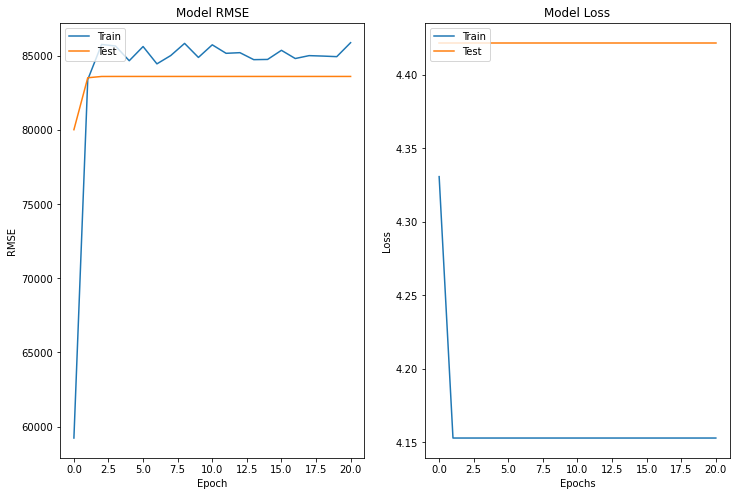

5/5 [==============================] - 1s 89ms/step


<ipython-input-14-9e032a6d7b88>:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values


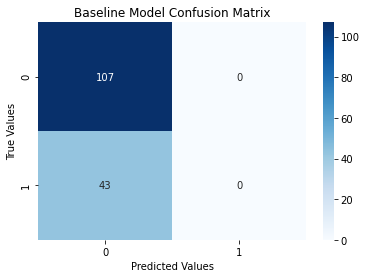

              precision    recall  f1-score   support

           0       0.71      1.00      0.83       107
           1       0.00      0.00      0.00        43

    accuracy                           0.71       150
   macro avg       0.36      0.50      0.42       150
weighted avg       0.51      0.71      0.59       150



C:\Users\18016\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
evaluate_model(history, model, test)

Plots for RMSE and loss are not particularly helpful because of the extremely high values on the first model epoch, but I will not choose to correct these failures at the moment because the model did not perform well anyways... like other models so far, this model is almost always choosing CE category. It seems like no signal is detected in this model.

## Dropout regularization

Goal for this model is to try some overfitting reduction strategies.

### Create and fit the model

In [21]:
model = models.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                    input_shape=(512, 512, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# add dropout regularization
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(1))

# Compile the model
model.compile(
    loss = 'binary_crossentropy',    
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse"), 'mae'],
    optimizer = tf.keras.optimizers.Adam(1e-3)
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 510, 510, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 508, 508, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 254, 254, 32)     0         
 )                                                               
                                                                 
 conv2d_8 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 250, 250, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                  

In [22]:
history = model.fit(
    x=np.array(train['img_arr'].to_list()),
    y=train['target'],
    batch_size=64,
    epochs=50,
    callbacks=[es, mc],
    validation_data=(np.array(test['img_arr'].to_list()), test['target'])
)

Epoch 1/50
10/10 [==============================] - 105s 10s/step - loss: 4.4545 - rmse: 3021.3689 - mae: 2282.3103 - val_loss: 4.4218 - val_rmse: 7762.7983 - val_mae: 7711.8716
Epoch 2/50
10/10 [==============================] - 99s 10s/step - loss: 4.1529 - rmse: 13481.6133 - mae: 12857.0918 - val_loss: 4.4218 - val_rmse: 19304.2656 - val_mae: 19175.7891
Epoch 3/50
10/10 [==============================] - 99s 10s/step - loss: 4.1529 - rmse: 22973.9141 - mae: 22567.4023 - val_loss: 4.4218 - val_rmse: 26300.2559 - val_mae: 26125.3242
Epoch 4/50
10/10 [==============================] - 100s 10s/step - loss: 4.1529 - rmse: 28234.1367 - mae: 27816.1328 - val_loss: 4.4218 - val_rmse: 29558.4922 - val_mae: 29362.2891
Epoch 5/50
10/10 [==============================] - 100s 10s/step - loss: 4.1529 - rmse: 30416.1875 - mae: 30000.8926 - val_loss: 4.4218 - val_rmse: 30923.0859 - val_mae: 30718.0742
Epoch 6/50
10/10 [==============================] - 101s 10s/step - loss: 4.1529 - rmse: 31779.7

### Evaluate the model

5/5 [==============================] - 4s 716ms/step - loss: 4.4218 - rmse: 31792.2480 - mae: 31581.6172
Test Loss: 4.421818733215332
Test RMSE: 31792.248046875
Test MAE: 31581.6171875


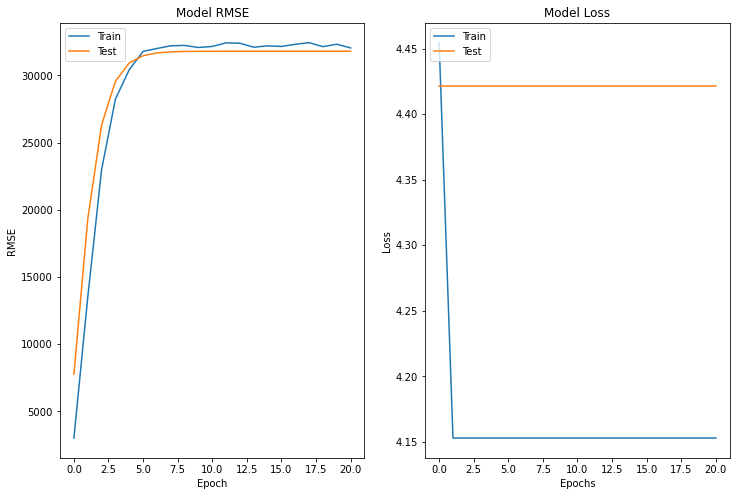

5/5 [==============================] - 4s 704ms/step


<ipython-input-14-9e032a6d7b88>:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values


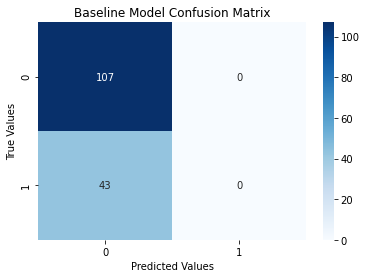

              precision    recall  f1-score   support

           0       0.71      1.00      0.83       107
           1       0.00      0.00      0.00        43

    accuracy                           0.71       150
   macro avg       0.36      0.50      0.42       150
weighted avg       0.51      0.71      0.59       150



In [23]:
evaluate_model(history, model, test)

Model again seems to not have done anything useful.

## EfficientNet model

Kaggle users for this competition have noted that EfficientNet seems to be generating some success. I will go ahead and try this model out.

Background on EfficientNet: EfficientNet is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of depth/width/resolution using a compound coefficient. The scaling parameter is compound in that it is a constant ratio between the dimensions.

In [24]:
from tensorflow.keras.applications import EfficientNetB0     # 224x224
from tensorflow.keras.applications import EfficientNetB7     # 600x600

Probably will not use EffNetB7 because of OOM issues.

### Image transformations

Need to preprocess the images as 224x224 for EfficientNetB0

In [25]:
def preprocess(image_path):
    slide = OpenSlide(image_path)     # create OpenSlide image object
    region = (0, 0)     # start at bottom left corner
    size = (10000, 10000)     # size is square 10kx10k pixels starting from 0
    image = slide.read_region(region, 0, size)     # read image with params
    image = image.resize(size=(224,224)).convert('RGB')     # resizing to 512x512
    image_arr = np.array(image)    # convert image to array
    return image_arr

Function will convert images to 3 channels and resize to 224x224 px. Then converts images to arrays to avoid OOM.

In [26]:
# apply function to images

# create copy of train_df to apply changes to
tdf2 = train_df.copy()
image_arrays2 = []

for i in tqdm(train_df['file_path']):
    img_a = preprocess(i)
    image_arrays2.append(img_a)
    
tdf2['img_arr'] = image_arrays2

tdf2.head()

100%|██████████| 748/748 [38:12<00:00,  3.06s/it]


,image_id,center_id,patient_id,image_num,label,file_path,img_arr
0,006388_0,11,006388,0,CE,C:\\Users\\18016\\Downloads\\train\\006388_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,008e5c_0,11,008e5c,0,CE,C:\\Users\\18016\\Downloads\\train\\008e5c_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,00c058_0,11,00c058,0,LAA,C:\\Users\\18016\\Downloads\\train\\00c058_0.tif,"[[[255, 241, 255], [255, 241, 255], [255, 241,..."
3,01adc5_0,11,01adc5,0,LAA,C:\\Users\\18016\\Downloads\\train\\01adc5_0.tif,"[[[246, 246, 244], [246, 246, 244], [246, 246,..."
4,026c97_0,4,026c97,0,CE,C:\\Users\\18016\\Downloads\\train\\026c97_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


It does take quite some time to convert the images to arrays.

### Train-test split

In [27]:
# also make a target column because I will need int labels for modeling

# 0 - CE & 1 - LAA
tdf2["target"] = tdf2["label"].apply(lambda x : 0 if x=="CE" else 1)

df_tt2 = tdf2.copy()
train, test = train_test_split(df_tt2, test_size=0.2, random_state=42, 
                               shuffle=True)

train

,image_id,center_id,patient_id,image_num,label,file_path,img_arr,target
593,d2c18a_0,11,d2c18a,0,LAA,C:\\Users\\18016\\Downloads\\train\\d2c18a_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
131,2b7304_1,3,2b7304,1,LAA,C:\\Users\\18016\\Downloads\\train\\2b7304_1.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
44,0d4164_0,11,0d4164,0,CE,C:\\Users\\18016\\Downloads\\train\\0d4164_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
70,15de51_0,4,15de51,0,LAA,C:\\Users\\18016\\Downloads\\train\\15de51_0.tif,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
670,e9c181_0,10,e9c181,0,CE,C:\\Users\\18016\\Downloads\\train\\e9c181_0.tif,"[[[255, 250, 255], [255, 250, 255], [255, 250,...",0
...,...,...,...,...,...,...,...,...
71,162cad_0,11,162cad,0,LAA,C:\\Users\\18016\\Downloads\\train\\162cad_0.tif,"[[[255, 241, 255], [255, 241, 255], [255, 241,...",1
106,23d2c1_1,7,23d2c1,1,CE,C:\\Users\\18016\\Downloads\\train\\23d2c1_1.tif,"[[[234, 216, 254], [234, 216, 254], [234, 216,...",0
270,56d177_2,7,56d177,2,CE,C:\\Users\\18016\\Downloads\\train\\56d177_2.tif,"[[[234, 216, 254], [234, 216, 254], [234, 216,...",0
435,91fee7_0,8,91fee7,0,CE,C:\\Users\\18016\\Downloads\\train\\91fee7_0.tif,"[[[255, 241, 255], [255, 241, 255], [255, 241,...",0


### Create and fit the model

I will also try some dropout layers to try to avoid overfitting.

In [28]:
efficient_net = EfficientNetB0(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='max',
    classes=2
)

model = models.Sequential()
model.add(efficient_net)
model.add(Dense(units=112, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=224, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1))

import tensorflow as tf

model.compile(
    loss = 'binary_crossentropy',    
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse"), 'mae'],
    optimizer = tf.keras.optimizers.Adam(1e-6)
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_7 (Dense)             (None, 112)               143472    
                                                                 
 dropout_4 (Dropout)         (None, 112)               0         
                                                                 
 dense_8 (Dense)             (None, 224)               25312     
                                                                 
 dropout_5 (Dropout)         (None, 224)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 225       
                                                                 
Total params: 4,218,580
Trainable params: 4,176,557
No

In [29]:
history = model.fit(
    x=np.array(train['img_arr'].to_list()),
    y=train['target'],
    batch_size=64,
    epochs=50,
    #callbacks=[es, mc],
    validation_data=(np.array(test['img_arr'].to_list()), test['target'])
)

Epoch 1/50
10/10 [==============================] - 48s 4s/step - loss: 6.5562 - rmse: 2.8609 - mae: 2.2196 - val_loss: 5.1092 - val_rmse: 1.2949 - val_mae: 0.9939
Epoch 2/50
10/10 [==============================] - 39s 4s/step - loss: 6.3445 - rmse: 2.8766 - mae: 2.1891 - val_loss: 5.0744 - val_rmse: 1.3051 - val_mae: 1.0400
Epoch 3/50
10/10 [==============================] - 39s 4s/step - loss: 6.3437 - rmse: 2.9502 - mae: 2.2400 - val_loss: 4.7231 - val_rmse: 1.3683 - val_mae: 1.0967
Epoch 4/50
10/10 [==============================] - 39s 4s/step - loss: 5.9741 - rmse: 2.8000 - mae: 2.1856 - val_loss: 4.4894 - val_rmse: 1.4074 - val_mae: 1.1289
Epoch 5/50
10/10 [==============================] - 39s 4s/step - loss: 6.3231 - rmse: 2.9160 - mae: 2.2455 - val_loss: 4.7321 - val_rmse: 1.4389 - val_mae: 1.1461
Epoch 6/50
10/10 [==============================] - 39s 4s/step - loss: 6.3200 - rmse: 2.8016 - mae: 2.2142 - val_loss: 4.6350 - val_rmse: 1.4603 - val_mae: 1.1605
Epoch 7/50
10/10

### Evaluate the model

5/5 [==============================] - 2s 416ms/step - loss: 5.0951 - rmse: 2.0100 - mae: 1.5587
Test Loss: 5.095141410827637
Test RMSE: 2.0100231170654297
Test MAE: 1.5586779117584229


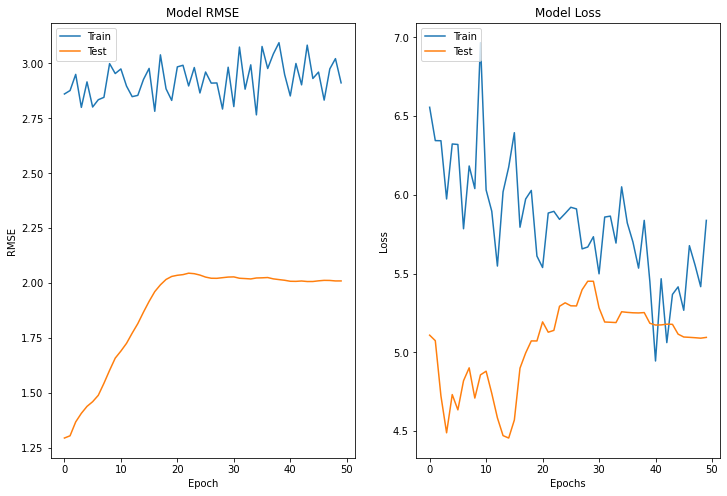

5/5 [==============================] - 3s 415ms/step


<ipython-input-14-9e032a6d7b88>:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values


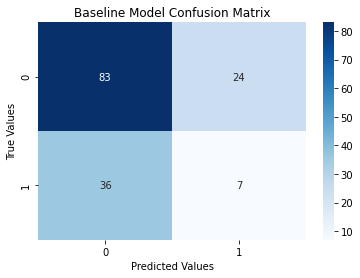

              precision    recall  f1-score   support

           0       0.70      0.78      0.73       107
           1       0.23      0.16      0.19        43

    accuracy                           0.60       150
   macro avg       0.46      0.47      0.46       150
weighted avg       0.56      0.60      0.58       150



In [30]:
evaluate_model(history, model, test)

Just from CM, it would be intuited that the model is a little bit worse than random guessing. Again, I'm mainly paying attention to the loss function, but it's important to keep track of what the model is doing and where it is classifying images.

## Xception Model

After speaking to my instructor (Abhineet), he recommended that I try Xception. This kind of CNN represents an "intermediate step in-between regular convolution and the depthwise separable convolution operation (a depthwise convolution followed by a pointwise convolution)." This quote is from a Francois Chollet [article](https://arxiv.org/abs/1610.02357) describing this model.

In [31]:
# import the Xception model from Keras
from tensorflow.keras.applications.xception import Xception

### Create and fit the model

In [32]:
xception_model = Xception(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='max',
    classes=2
)

model = models.Sequential()
model.add(xception_model)
model.add(Dense(units=112, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=224, activation = 'relu'))
model.add(Dropout(0.25))

# sigmoid activation with binary crossentropy loss
model.add(Dense(1, activation = 'sigmoid'))

model.compile(
    loss = 'binary_crossentropy',    
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse"), 'mae'],
    optimizer = tf.keras.optimizers.Adam(1e-6)
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_10 (Dense)            (None, 112)               229488    
                                                                 
 dropout_6 (Dropout)         (None, 112)               0         
                                                                 
 dense_11 (Dense)            (None, 224)               25312     
                                                                 
 dropout_7 (Dropout)         (None, 224)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 225       
                                                                 
Total params: 21,116,505
Trainable params: 21,061,977


In [33]:
history = model.fit(
    x=np.array(train['img_arr'].to_list()),
    y=train['target'],
    batch_size=64,
    epochs=150,
    callbacks=[es, mc],
    validation_data=(np.array(test['img_arr'].to_list()), test['target'])
)

Epoch 1/150
10/10 [==============================] - 78s 7s/step - loss: 0.6892 - rmse: 0.4956 - mae: 0.4667 - val_loss: 0.7056 - val_rmse: 0.4801 - val_mae: 0.3334
Epoch 2/150
10/10 [==============================] - 70s 7s/step - loss: 0.6690 - rmse: 0.4869 - mae: 0.4602 - val_loss: 0.6095 - val_rmse: 0.4563 - val_mae: 0.3814
Epoch 3/150
10/10 [==============================] - 70s 7s/step - loss: 0.6797 - rmse: 0.4921 - mae: 0.4620 - val_loss: 0.6145 - val_rmse: 0.4598 - val_mae: 0.4369
Epoch 4/150
10/10 [==============================] - 70s 7s/step - loss: 0.6726 - rmse: 0.4871 - mae: 0.4574 - val_loss: 0.6383 - val_rmse: 0.4725 - val_mae: 0.4535
Epoch 5/150
10/10 [==============================] - 70s 7s/step - loss: 0.6879 - rmse: 0.4946 - mae: 0.4648 - val_loss: 0.6374 - val_rmse: 0.4706 - val_mae: 0.4413
Epoch 6/150
10/10 [==============================] - 70s 7s/step - loss: 0.6432 - rmse: 0.4752 - mae: 0.4461 - val_loss: 0.6400 - val_rmse: 0.4692 - val_mae: 0.4302
Epoch 7/15

### Evaluate the model

5/5 [==============================] - 3s 632ms/step - loss: 0.6236 - rmse: 0.4633 - mae: 0.4227
Test Loss: 0.623609185218811
Test RMSE: 0.4632795453071594
Test MAE: 0.4226817190647125


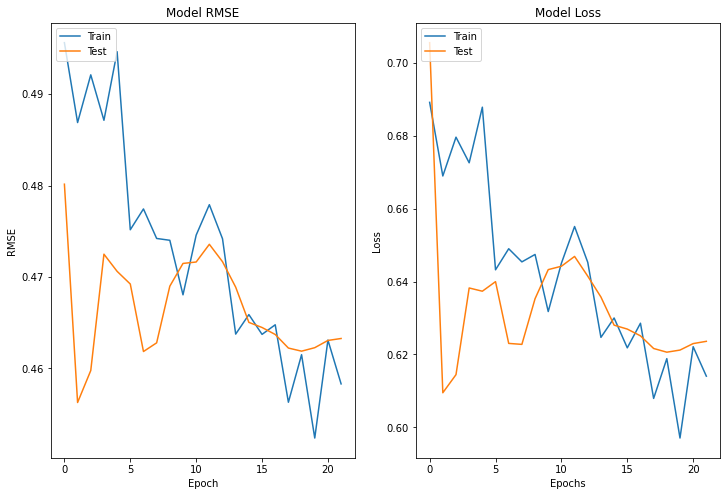

5/5 [==============================] - 4s 644ms/step


<ipython-input-14-9e032a6d7b88>:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values


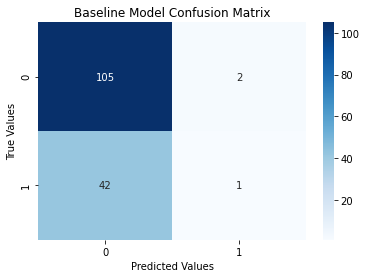

              precision    recall  f1-score   support

           0       0.71      0.98      0.83       107
           1       0.33      0.02      0.04        43

    accuracy                           0.71       150
   macro avg       0.52      0.50      0.44       150
weighted avg       0.61      0.71      0.60       150



In [34]:
evaluate_model(history, model, test)

The loss is better than baseline, but the model is just predicting CE category for every image. The bottom or valley of the loss and RMSE is very clear from the graphs.

# Import png image dataset

I think this dataset will be much more manageable to work with, and hopefully higher resolution of each image will be allowed in model iterations involving this dataset. The goal is for higher resolution to capture features within the data.

In [35]:
# load in the dataset
train_path = r"C:\\Users\\18016\\Desktop\\train_images_cleaned\\"
train_df["file_path"] = train_df["image_id"].apply(lambda x: train_path + x + ".png")
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path
0,006388_0,11,006388,0,CE,C:\\Users\\18016\\Desktop\\train_images_cleane...
1,008e5c_0,11,008e5c,0,CE,C:\\Users\\18016\\Desktop\\train_images_cleane...
2,00c058_0,11,00c058,0,LAA,C:\\Users\\18016\\Desktop\\train_images_cleane...
3,01adc5_0,11,01adc5,0,LAA,C:\\Users\\18016\\Desktop\\train_images_cleane...
4,026c97_0,4,026c97,0,CE,C:\\Users\\18016\\Desktop\\train_images_cleane...


## Clean the dataset

In [36]:
# follow same process as in 1.3

# remove following ids from train_df:
# b894f4_0, 6baf51_0, 7b9aaa_0, 5adc4c_0, bb06a5_0, and e26a04_0
train_df = train_df[(train_df.image_id != 'b894f4_0') & 
                     (train_df.image_id != '6baf51_0') & 
                     (train_df.image_id != '7b9aaa_0') &
                     (train_df.image_id != '5adc4c_0') & 
                     (train_df.image_id != 'bb06a5_0') & 
                     (train_df.image_id != 'e26a04_0')]

# also, reset the index of train_df
train_df = train_df.reset_index(drop=True)

These images are removed due to issues with them being distorted, blurry, or having some other issue. These were mainly identified by Kaggle users.

## Preview an image

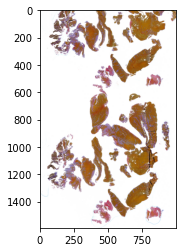

In [37]:
img = Image.open(train_df.file_path[0])
plt.imshow(img)

## Preprocess images

Normalize and permute with ImageDataGenerator, perform train-test-split, and fit datagenerator to train and test set.

In [38]:
# use ImageDataGenerator
permutes = ImageDataGenerator(
    rescale = 1. / 255,     # normalize values btwn 0-1
    shear_range = 0.2,     # this distorts the image along an axis
    zoom_range = 0.2,     # range for random zoom
    horizontal_flip = True     # random horizontal flip
)

# 80-20 standard split
df_tt = train_df.copy()
train, test = train_test_split(df_tt, test_size=0.2, random_state=42, 
                               shuffle=True)


# fit the image modifier/permuter
# use target size of 299x299 pixels. That is the default input image size for 
# Xception. Maybe it will perform better with this size, but I imagine that
# larger (more resolute) images would perform better in general.
train_gen = permutes.flow_from_dataframe(dataframe=train, x_col='file_path',
                                         y_col='label', target_size=(299,299),
                                         class_mode='binary', batch_size=16,
                                         seed=42)

test_gen = permutes.flow_from_dataframe(dataframe=test, x_col='file_path',
                                         y_col='label', target_size=(299,299),
                                         class_mode='binary', batch_size=16,
                                         seed=42)

Found 598 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


Image size is 299x299 because Xception defaults to this size. I want to try this size... It's so specific that maybe there is some optimization for it, but I imagine more resolute images work better in general.

## Xception Model

### Create and fit model

Use the default input size of 299x299 pixels for Xception.

In [43]:
xception_model = Xception(
    weights='imagenet',
    input_shape=(299, 299, 3),
    include_top=False,
    pooling='max',
    classes=2
)

# using dropout of 0.5 in hopes of decreasing overfitting.

model = models.Sequential()
model.add(xception_model)
model.add(Dense(units=229, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=458, activation = 'relu'))
model.add(Dropout(0.5))

# sigmoid activation with binary crossentropy loss
model.add(Dense(1, activation = 'sigmoid'))

model.compile(
    loss = 'binary_crossentropy',    
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse"), 'mae'],
    optimizer = tf.keras.optimizers.Adam(1e-6)
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_19 (Dense)            (None, 229)               469221    
                                                                 
 dropout_12 (Dropout)        (None, 229)               0         
                                                                 
 dense_20 (Dense)            (None, 458)               105340    
                                                                 
 dropout_13 (Dropout)        (None, 458)               0         
                                                                 
 dense_21 (Dense)            (None, 1)                 459       
                                                                 
Total params: 21,436,500
Trainable params: 21,381,972


In [44]:
history = model.fit(
    x=train_gen,
    steps_per_epoch=train_gen.n//train_gen.batch_size,
    validation_data=test_gen,
    validation_steps=test_gen.n//test_gen.batch_size,
    epochs=50,
    callbacks=[es, mc]
)

Epoch 1/50
37/37 [==============================] - 214s 6s/step - loss: 0.9015 - rmse: 0.5234 - mae: 0.4069 - val_loss: 0.6071 - val_rmse: 0.4533 - val_mae: 0.3822
Epoch 2/50
37/37 [==============================] - 191s 5s/step - loss: 0.9000 - rmse: 0.5343 - mae: 0.4175 - val_loss: 0.6544 - val_rmse: 0.4720 - val_mae: 0.3962
Epoch 3/50
37/37 [==============================] - 192s 5s/step - loss: 0.9178 - rmse: 0.5273 - mae: 0.4081 - val_loss: 0.6381 - val_rmse: 0.4643 - val_mae: 0.3815
Epoch 4/50
37/37 [==============================] - 189s 5s/step - loss: 0.8726 - rmse: 0.5196 - mae: 0.4036 - val_loss: 0.6541 - val_rmse: 0.4723 - val_mae: 0.3977
Epoch 5/50
37/37 [==============================] - 189s 5s/step - loss: 0.9311 - rmse: 0.5339 - mae: 0.4152 - val_loss: 0.6420 - val_rmse: 0.4679 - val_mae: 0.3978
Epoch 6/50
37/37 [==============================] - 187s 5s/step - loss: 0.8954 - rmse: 0.5254 - mae: 0.4120 - val_loss: 0.5746 - val_rmse: 0.4410 - val_mae: 0.3664
Epoch 7/50

### Evaluate the model

10/10 [==============================] - 9s 809ms/step - loss: 0.5890 - rmse: 0.4480 - mae: 0.3998
Test Loss: 0.5890403389930725
Test RMSE: 0.4479782283306122
Test MAE: 0.39976587891578674


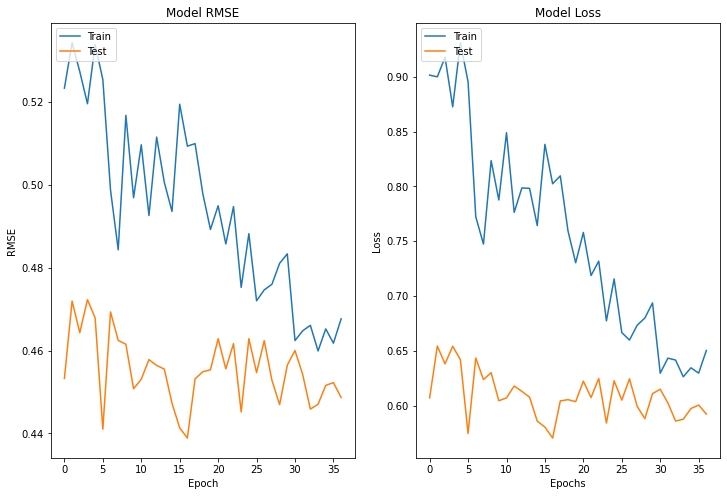

In [45]:
test_loss, test_rmse, test_mae = history.model.evaluate(test_gen)
print(f'Test Loss: {test_loss}')
print(f'Test RMSE: {test_rmse}')
print(f'Test MAE: {test_mae}')

# create plots for accuracy and loss
fig, ax = plt.subplots(1, 2, figsize = (12,8))
ax[0].plot(history.history['rmse'])
ax[0].plot(history.history['val_rmse'])
ax[0].set_title('Model RMSE')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('RMSE')
ax[0].legend(['Train', 'Test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Test'], loc='upper left')

plt.show()

In [46]:
# need integer labels for more evaluation
df_test_tmp = test.copy()
df_test_tmp.loc[df_test_tmp['label'] == 'CE', 'label'] = 0     # CE is now 0
df_test_tmp.loc[df_test_tmp['label'] == 'LAA', 'label'] = 1     # LAA is now 1

10/10 [==============================] - 9s 818ms/step


<ipython-input-47-c4d092d549eb>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values


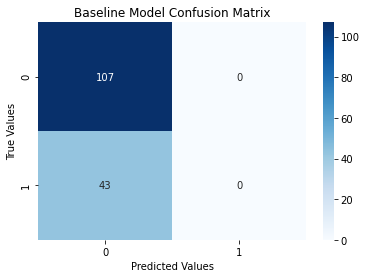

In [47]:
# Create predictions for the model
y_hat_tmp = history.model.predict(test_gen)

# classify y_hat as either 0 or 1 based on if val is < or >= to 0.5
thresh = 0.5
y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values

y_t = df_test_tmp.label.astype(int)

cm_vals = confusion_matrix(y_t, y_hat)     # get confusion matrix values

# plot confusion matrix values
sns.heatmap(
    cm_vals, 
    annot=True, 
    cmap='Blues', 
    fmt='0.5g'
)

plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Baseline Model Confusion Matrix')
plt.show()

Unfortunately, this model is guessing CE category almost every time it makes a prediction.

Notice the lower loss here. Lowest loss score thus far.

## Xception Model retry

Maybe higher resolution will allow for better predictions. I am going to try to double the resolution used in the previous model from 299x299 to 598x598. 

In [48]:
train_gen = permutes.flow_from_dataframe(dataframe=train, x_col='file_path',
                                         y_col='label', target_size=(598,598),
                                         class_mode='binary', batch_size=16,
                                         seed=42)

test_gen = permutes.flow_from_dataframe(dataframe=test, x_col='file_path',
                                         y_col='label', target_size=(598,598),
                                         class_mode='binary', batch_size=16,
                                         seed=42)

Found 598 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


### Create and fit model

In [49]:
xception_model = Xception(
    weights='imagenet',
    input_shape=(598, 598, 3),
    include_top=False,
    pooling='max',
    classes=2
)

# using dropout of 0.5 in hopes of decreasing overfitting.

model = models.Sequential()
model.add(xception_model)
model.add(Dense(units=299, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=598, activation = 'relu'))
model.add(Dropout(0.5))

# sigmoid activation with binary crossentropy loss
model.add(Dense(1, activation = 'sigmoid'))

model.compile(
    loss = 'binary_crossentropy',    
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse"), 'mae'],
    optimizer = tf.keras.optimizers.Adam(1e-6)
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_22 (Dense)            (None, 299)               612651    
                                                                 
 dropout_14 (Dropout)        (None, 299)               0         
                                                                 
 dense_23 (Dense)            (None, 598)               179400    
                                                                 
 dropout_15 (Dropout)        (None, 598)               0         
                                                                 
 dense_24 (Dense)            (None, 1)                 599       
                                                                 
Total params: 21,654,130
Trainable params: 21,599,602


In [50]:
history = model.fit(
    x=train_gen,
    steps_per_epoch=train_gen.n//train_gen.batch_size,
    validation_data=test_gen,
    validation_steps=test_gen.n//test_gen.batch_size,
    epochs=50,
    callbacks=[es, mc]
)

Epoch 1/50
37/37 [==============================] - 846s 23s/step - loss: 1.4325 - rmse: 0.6354 - mae: 0.5285 - val_loss: 0.6990 - val_rmse: 0.5022 - val_mae: 0.4865
Epoch 2/50
37/37 [==============================] - 803s 22s/step - loss: 1.2269 - rmse: 0.6028 - mae: 0.4972 - val_loss: 0.6146 - val_rmse: 0.4618 - val_mae: 0.4284
Epoch 3/50
37/37 [==============================] - 804s 22s/step - loss: 1.2476 - rmse: 0.5994 - mae: 0.4829 - val_loss: 0.6173 - val_rmse: 0.4594 - val_mae: 0.3902
Epoch 4/50
37/37 [==============================] - 808s 22s/step - loss: 1.1159 - rmse: 0.5728 - mae: 0.4624 - val_loss: 0.6019 - val_rmse: 0.4464 - val_mae: 0.3558
Epoch 5/50
37/37 [==============================] - 815s 22s/step - loss: 1.0989 - rmse: 0.5727 - mae: 0.4586 - val_loss: 0.6715 - val_rmse: 0.4723 - val_mae: 0.3549
Epoch 6/50
37/37 [==============================] - 827s 22s/step - loss: 1.0313 - rmse: 0.5514 - mae: 0.4318 - val_loss: 0.6618 - val_rmse: 0.4691 - val_mae: 0.3359
Epoc

### Evaluate the model

10/10 [==============================] - 39s 4s/step - loss: 0.6321 - rmse: 0.4619 - mae: 0.3612
Test Loss: 0.6321384906768799
Test RMSE: 0.4618609845638275
Test MAE: 0.36124953627586365


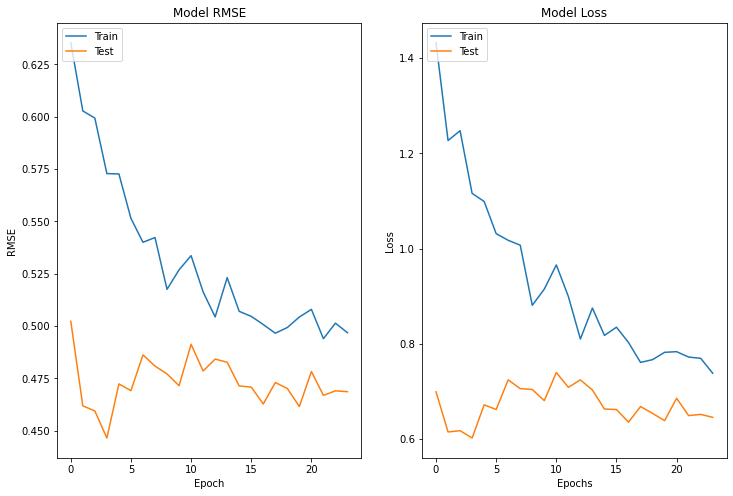

In [51]:
test_loss, test_rmse, test_mae = history.model.evaluate(test_gen)
print(f'Test Loss: {test_loss}')
print(f'Test RMSE: {test_rmse}')
print(f'Test MAE: {test_mae}')

# create plots for accuracy and loss
fig, ax = plt.subplots(1, 2, figsize = (12,8))
ax[0].plot(history.history['rmse'])
ax[0].plot(history.history['val_rmse'])
ax[0].set_title('Model RMSE')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('RMSE')
ax[0].legend(['Train', 'Test'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Test'], loc='upper left')

plt.show()

The loss and RMSE of the test function is flat throughout the duration but looks like maybe they would eventually converge. The loss is just a bit more than the previous Xception model.

10/10 [==============================] - 38s 4s/step


<ipython-input-52-14eb97735682>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values


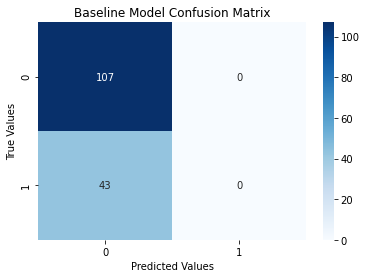

In [52]:
# need integer labels for more evaluation
df_test_tmp = test.copy()
df_test_tmp.loc[df_test_tmp['label'] == 'CE', 'label'] = 0     # CE is now 0
df_test_tmp.loc[df_test_tmp['label'] == 'LAA', 'label'] = 1     # LAA is now 1

# Create predictions for the model
y_hat_tmp = history.model.predict(test_gen)

# classify y_hat as either 0 or 1 based on if val is < or >= to 0.5
thresh = 0.5
y_hat = (y_hat_tmp > thresh).astype(np.int)     # cast 0 or 1 to y_hat values

y_t = df_test_tmp.label.astype(int)

cm_vals = confusion_matrix(y_t, y_hat)     # get confusion matrix values

# plot confusion matrix values
sns.heatmap(
    cm_vals, 
    annot=True, 
    cmap='Blues', 
    fmt='0.5g'
)

plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Baseline Model Confusion Matrix')
plt.show()

Again, the model is predicting that each image represents the CE category.

# Modeling Conclusions

Ultimately the results here are very disappointing. This dataset is exceptionally hard and it's impossible to not lose most of the image's resolution when preprocessing the image because it is so easy to run into OOM issues.

Most of the models seem to essentially be guessing CE category for every validation image. I highly doubt there is any sort feature detection involved in any of these images (i.e. models do not detect any pattern in particular differentiating the two categories). 

One of the Xception models performed slightly better in terms of loss than the baseline model. It might be *slightly* more confident in guessing the images when they are CE than the baseline, but it should be assumed that both models are guessing CE for each image with roughly the same confidence. It should be assumed there is not a difference between the performance of these two models especially considering there are no indications of a significant difference in any metric - even .06 or so difference in loss does not indicate significance. This difference could be attributed to randomness in how confident the models are for each individual image in the test set.

## Actionable recommendations to the stakeholder

To reiterate clarify recommendations for the stakeholder, I am including the "Actionable recommendations" section from the Google Colab notebook here as well: <br>
To create a more effective predictive model, a diagnostic tool should be created that will automatically read in new data and automatically make predictions that will help physicians with a diagnosis. This diagnostic tool should take advantage of new Whole Slide images from each patient, and it should also incorporate other data such as mass spectrometry readings of protein content from the blood clot and additional biomarkers from each patient such as whether or not the patient has a history of cardioembolic or large artery atherosclerosis strokes in their family. With the incorporation of new data, the model will continue learning and refining predictions to allow for better predictions.